## Necessary Imports

In [72]:
import matplotlib.pyplot as plt

from nltk import word_tokenize
import nltk
nltk.download('punkt')
import numpy as np

import re

import pandas as pd
from project_functions import preprocess_tweet

import seaborn as sns

from textblob import TextBlob
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nickwilders/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Text Pre-Processing

### In this notebook, the text preprocessing process will be outlined, in preparation for NMF topic modeling

Visualization functions for individual users and cashtags will also be outlined. 

In [116]:
# Upload cleaned corpous of tweets

total_tweets = pd.read_csv('data/total_tweets.csv')

In [75]:
# preprocess text with outside function

total_tweets['tokens'] = total_tweets.apply(preprocess_tweet, axis=1).apply(word_tokenize) 

total_tweets.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,original_index,date,screen_name,tweet,tweet_id,cashtag,hashtag,primary_cashtag,year,month,tokens,Polarity
0,0,0,0,0,0,0.0,2020-11-09 16:10:48,buysellshort,$JAKK $5 break scanner squeeze retailer mania ...,1.325833e+18,['$JAKK'],[],$JAKK,2020,11,"[break, scanner, squeeze, retailer, mania, tod...",0.0
1,1,1,1,1,1,1.0,2020-11-06 14:43:57,buysellshort,$WTER https://t.co/JVc3CjcG3h,1.324724e+18,['$WTER'],[],$WTER,2020,11,[],0.0
2,2,2,2,2,2,2.0,2020-11-05 16:46:02,buysellshort,$SXTC china pennies on fire today 50% upside o...,1.324393e+18,['$SXTC'],[],$SXTC,2020,11,"[china, pennies, today, upside, chart]",0.0
3,3,3,3,3,3,3.0,2020-11-05 20:29:30,buysellshort,$SNDL add this vol i see those late day chaser...,1.324449e+18,['$SNDL'],[],$SNDL,2020,11,"[add, vol, late, day, chasers, coming]",-0.3
4,4,4,4,4,4,4.0,2020-11-06 15:41:04,buysellshort,$SNDL https://t.co/BJ9oqqY3EO,1.324739e+18,['$SNDL'],[],$SNDL,2020,11,[],0.0


In [76]:
# Use TextBlob to get sentiment based on tweet content

def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

total_tweets['Polarity'] = total_tweets['tweet'].apply(getPolarity)

In [77]:
# View polarity range and value counts, -1 is most negative and 1 is most positive (with a strong bias towards
# positivity)

polarity = total_tweets['Polarity'].value_counts().sort_index()
polarity

-1.000000     121
-1.000000       3
-0.976562       5
-0.937500       4
-0.910000       1
             ... 
 0.975000      29
 0.976562      31
 0.976563       1
 0.988281       2
 1.000000    1605
Name: Polarity, Length: 5334, dtype: int64

In [81]:
# Sort polarity, and drop any values that are purely negative, neutral, or positive

polarity = total_tweets['Polarity'].value_counts().sort_index()
polarity = polarity.drop(labels=[-1,0,1])
polarity

-1.000000     3
-0.976562     5
-0.937500     4
-0.910000     1
-0.900000     6
             ..
 0.968750     4
 0.975000    29
 0.976562    31
 0.976563     1
 0.988281     2
Name: Polarity, Length: 5331, dtype: int64

### Visualization Function - View Polarity (sentiment) by Cashtag

In [124]:
# define polarity_by_cashtag to extract the Twitter polarity for individual cashtags

def polarity_by_cashtag(cashtag, year=None, month=None):
    
    import matplotlib.ticker as ticker
    
    tweets_by_user = total_tweets[total_tweets.primary_cashtag == cashtag]
    
    polarity = tweets_by_user['Polarity'].value_counts().sort_index()
    #polarity = polarity.drop(labels=[-1,0,1])
    out = pd.cut(polarity.index, bins=list(np.linspace(-1,1,21)), include_lowest=True)
    out = out.value_counts()
    
    fig, ax = plt.subplots(figsize=(10,6))
    plt.xlim(-1,20)
    
    cashtag_no_dollar = cashtag[1:]

    sns.barplot(out.index, out.values, palette='rocket')
    ax.set_yscale('log')
    ax.set_title(f'Tweet Polarity Distribution for {cashtag_no_dollar}\n', fontsize = 20)
    ax.set_xlabel('\nTweet Polarity', fontsize=14)
    ax.set_ylabel('Amount of Tweets', fontsize=14, rotation=0, labelpad=75)
    ax.axvline(x=8, linewidth=2, color='black', alpha=.6, linestyle='--')
    ax.axvline(x=11, linewidth=2, color='black', alpha=.6, linestyle='--')
    ax.axvspan(-1,8, color ='orange',alpha=.1)
    ax.axvspan(8,11, color ='gray',alpha=.1)
    ax.axvspan(11,20, color ='red',alpha=.1)
    ax.set(xticklabels=['','','','','Negative','','','','','','Neutral','','','','','','Positive','','',''], yticklabels=[])
    ax.set_xticks(list(np.linspace(0,20,11)))
    ax.grid(False)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()
    
    cashtag_no_dollar = cashtag[1:]
    
    plt.savefig(f'images/cashtags/polarity_distribution_{cashtag_no_dollar}');
    

In [107]:
# make list of fifty most popular stocks in dataset

popular_stocks = total_tweets.groupby('primary_cashtag').count().sort_values(by='year').tail(50).index
popular_stocks = popular_stocks.tolist()

popular_stocks

Index(['$HEB', '$AXXA', '$BIOF', '$XBIO', '$CYCC', '$CHCI', '$DEJ', '$RNN',
       '$GLUU', '$SMH', '$MARK', '$WAVX', '$TPTW', '$OPTT', '$PLUG', '$PEIX',
       '$RBII', '$OPTI', '$GEVO', '$NKLA', '$LFAP', '$FSI', '$VMNT', '$IBIO',
       '$ASTI', '$CRGED', '$DCTH', '$DIA', '$MCZ', '$DSGT', '$MVIS', '$TSLA',
       '$GNUS', '$ENZC', '$SBES', '$COOL', '$SPAQ', '$HDII', '$GRNF', '$IDEX',
       '$STUDY', '$GENE', '$PASO', '$CLSH', '$AAPL', '$TLSS', '$VRUS', '$TWTR',
       '$SPOM', '$FB'],
      dtype='object', name='primary_cashtag')

In [120]:
# View features of most popular cashtags

total_tweets[total_tweets['primary_cashtag'].isin(popular_stocks)].groupby('primary_cashtag').mean().sort_values(by='Polarity').head(60)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,original_index,tweet_id,year,month,Polarity
primary_cashtag,,,,,,,,,,
$BIOF,15897.305389,15897.305389,15897.305389,15897.305389,15897.305389,25.622754,1.951457e+17,2011.676647,8.185629,0.042700
$ASTI,16113.338521,16113.338521,16113.338521,16113.338521,16113.338521,24.287938,2.668575e+17,2012.420233,5.770428,0.067203
$SMH,17722.405128,17722.405128,17722.405128,17722.405128,17722.405128,24.625641,1.122977e+17,2010.923077,8.558974,0.069639
$XBIO,79712.850299,79712.850299,79712.850299,79712.850299,79712.850299,22.988024,1.189990e+18,2019.341317,6.275449,0.074631
$CHCI,76067.725275,76067.725275,76067.725275,76067.725275,76067.725275,24.016484,8.867671e+17,2016.978022,7.307692,0.075719
$DIA,47501.764925,47501.764925,47501.764925,47501.764925,47501.764925,23.917910,9.521088e+17,2017.466418,6.750000,0.077868
$SPAQ,73469.972973,73469.972973,73469.972973,73469.972973,73469.972973,24.867868,1.300674e+18,2020.000000,8.453453,0.081022
$LFAP,85002.966667,85002.966667,85002.966667,85002.966667,85002.966667,23.837500,6.230158e+17,2015.033333,6.508333,0.081815
$RNN,11930.578125,11930.578125,11930.578125,11930.578125,11930.578125,24.812500,2.683920e+17,2012.432292,5.593750,0.083371


/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


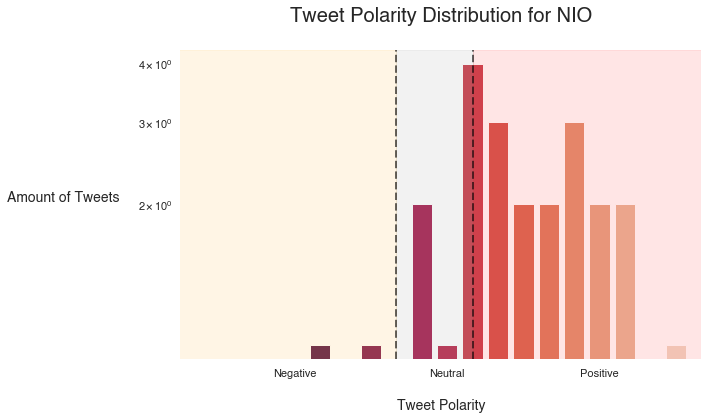

In [125]:
polarity_by_cashtag('$NIO')

#### Top 10 Cashtag Polarity (Visualization)

/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

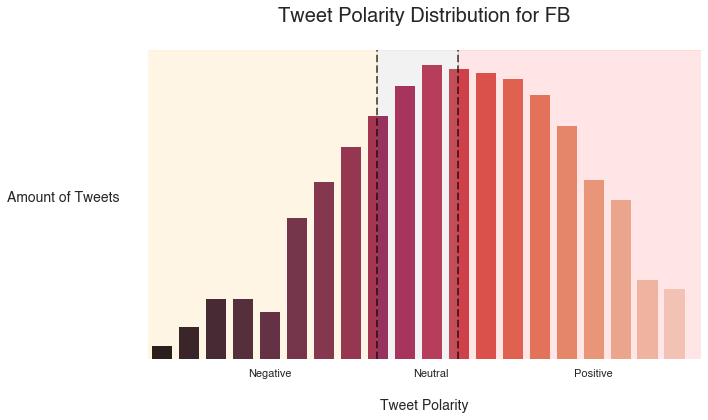

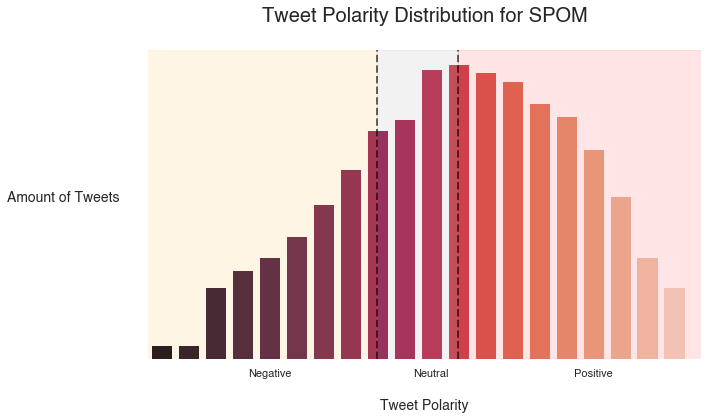

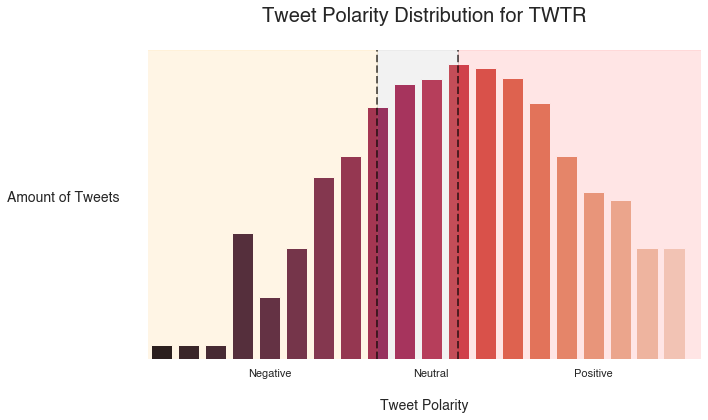

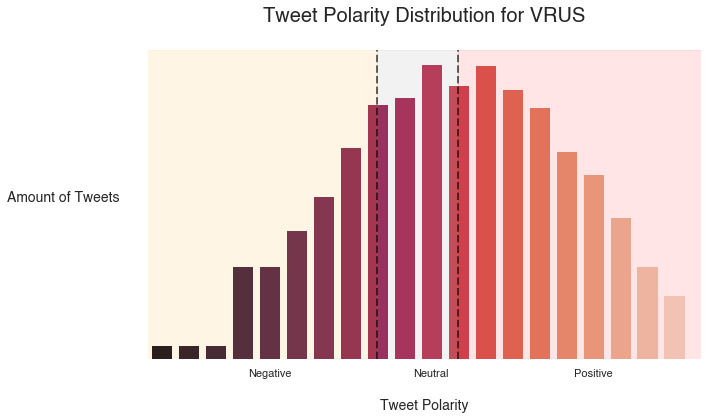

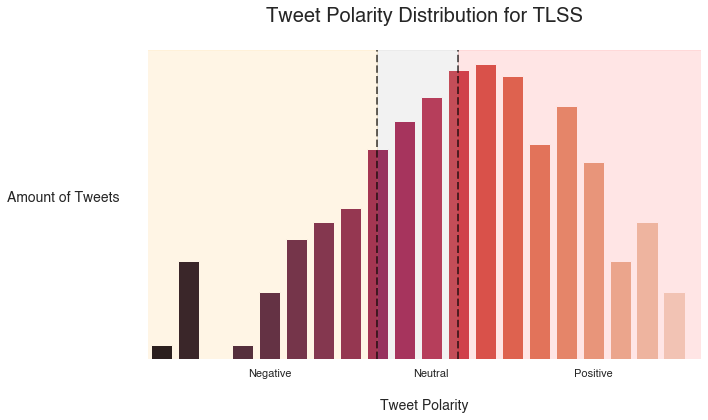

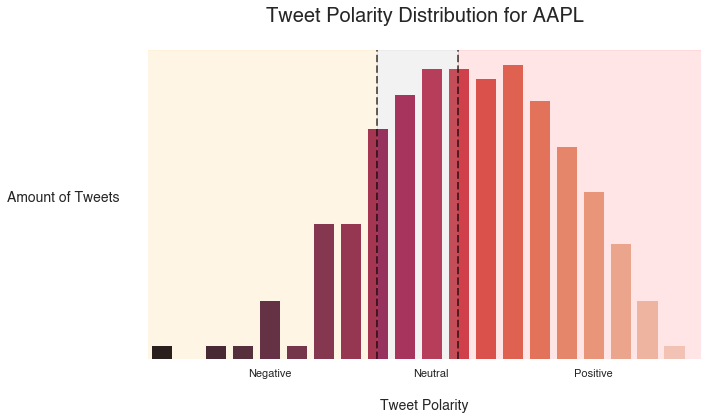

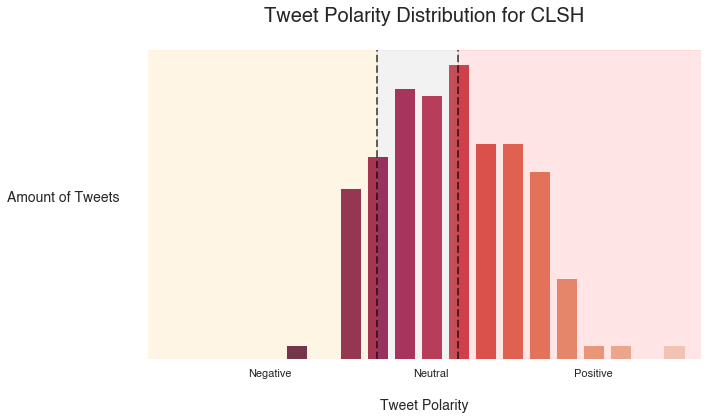

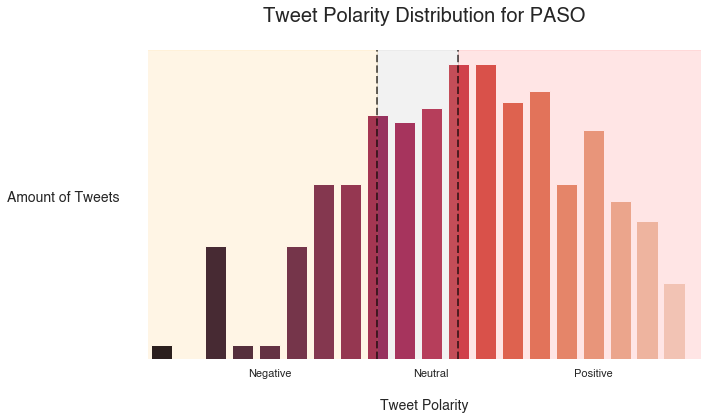

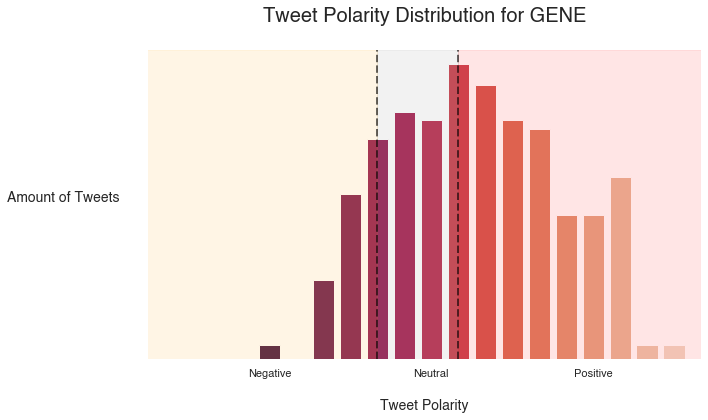

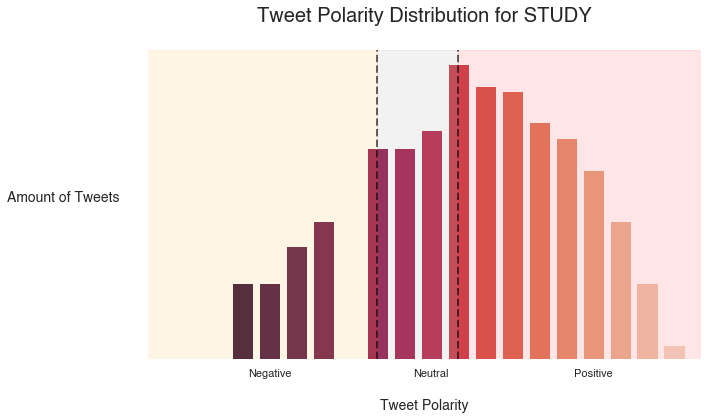

In [69]:
# Create visuals for ten most popular cashtags

top_cashtags = total_tweets.primary_cashtag.value_counts().head(10).index

for cashtag in top_cashtags:
    polarity_by_cashtag(cashtag)

### Visualization Function - View Polarity (sentiment) by User

In [54]:
def polarity_by_user(username):
    
    import matplotlib.ticker as ticker
    
    tweets_by_user = total_tweets[total_tweets.screen_name == username]
    
    polarity = tweets_by_user['Polarity'].value_counts().sort_index()
    polarity = polarity.drop(labels=[-1,0,1])
    out = pd.cut(polarity.index, bins=list(np.linspace(-1,1,21)), include_lowest=True)
    out = out.value_counts()
    
    fig, ax = plt.subplots(figsize=(10,6))
    plt.xlim(-1,20)

    sns.barplot(out.index, out.values, palette='rocket')
    sns.set_theme(style='whitegrid',font='Helvetica')
    ax.set_yscale('log')
    ax.set_title(f'Tweet Polarity Distribution for {username}\n', fontsize = 20)
    ax.set_xlabel('\nTweet Polarity', fontsize=14)
    ax.axvline(x=8, linewidth=2, color='black', alpha=.6, linestyle='--')
    ax.axvline(x=11, linewidth=2, color='black', alpha=.6, linestyle='--')
    ax.axvspan(-1,8, color ='orange',alpha=.1)
    ax.axvspan(8,11, color ='gray',alpha=.1)
    ax.axvspan(11,20, color ='red',alpha=.1)
    ax.set(xticklabels=['','','','','Negative','','','','','','Neutral','','','','','','Positive','','',''], yticklabels=[])
    ax.set_xticks(list(np.linspace(0,20,11)))
    ax.grid(False)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) 
    
    ax.set_ylabel('Amount of Tweets', fontsize=14, rotation=0, labelpad=75)
    
    plt.tight_layout()
    
    plt.savefig(f'images/polarity/{username}_polarity_distribution');
    
    

In [26]:
total_tweets.to_csv('data/total_tweets.csv')

/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

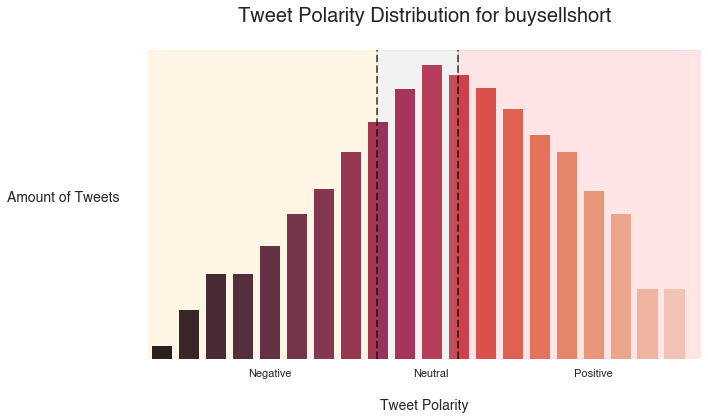

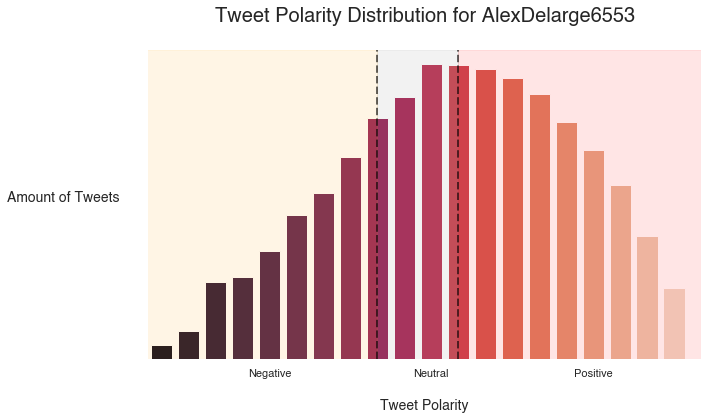

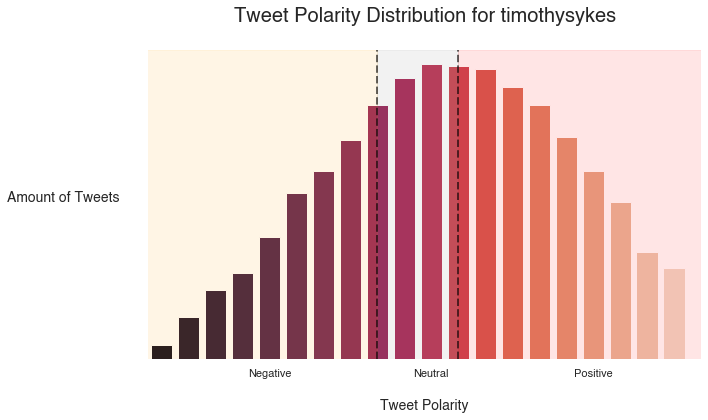

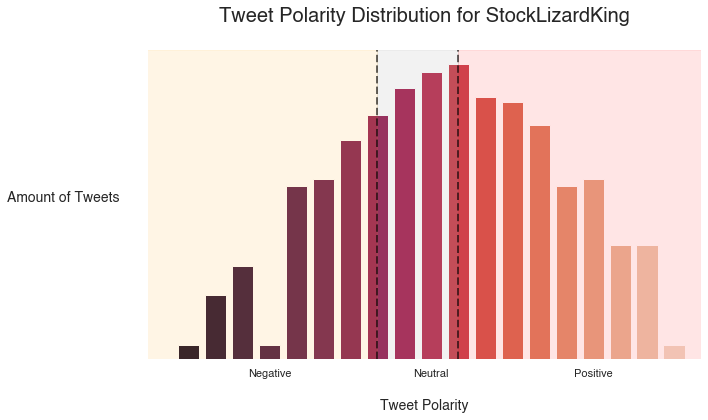

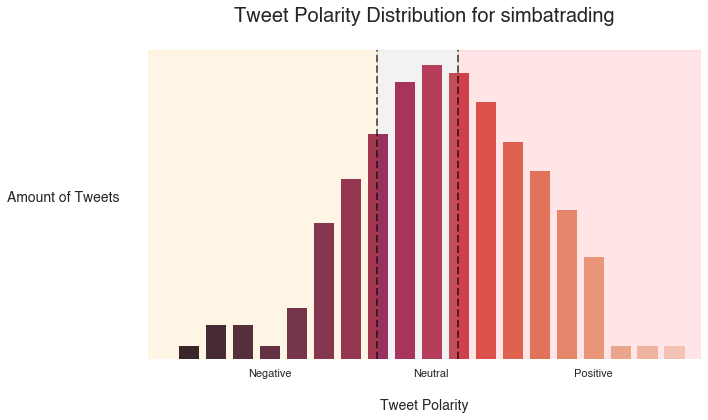

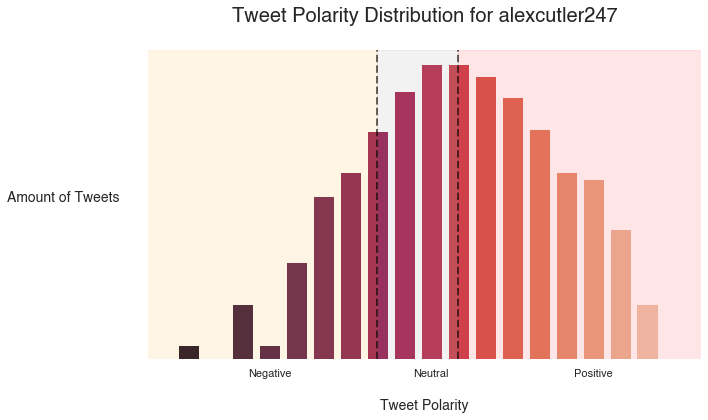

In [56]:
# Create visualization of polarity for six Penny Stock moguls 

users = ['buysellshort', 'AlexDelarge6553', 'timothysykes',
       'StockLizardKing', 'simbatrading', 'alexcutler247']

users.sort

for username in users:
    polarity_by_user(username)

### Penny Stock mogul Word Cloud generation

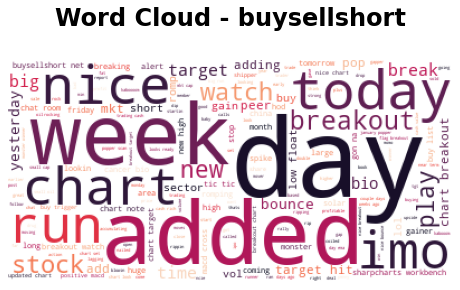

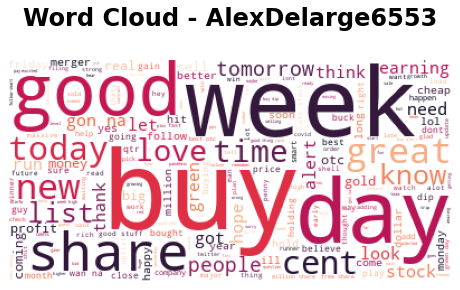

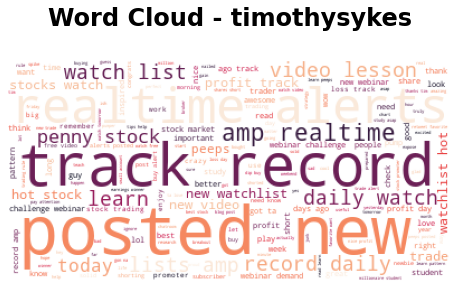

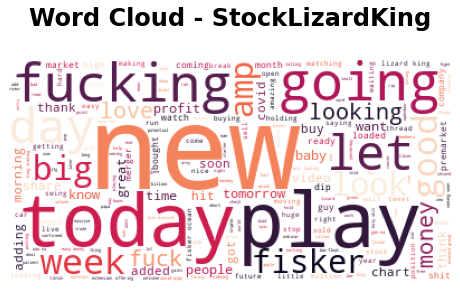

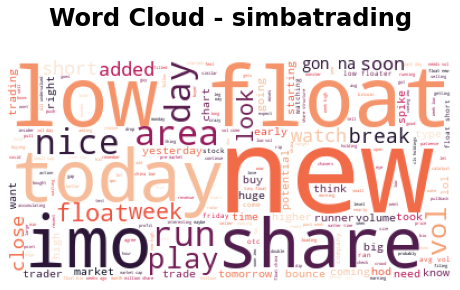

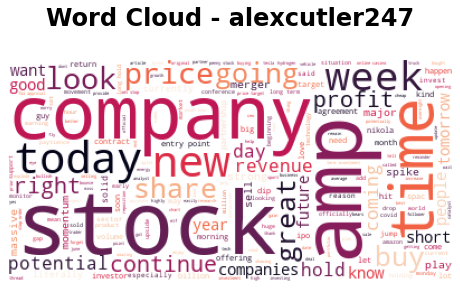

In [41]:
# Generate word clouds

users = ['buysellshort', 'AlexDelarge6553', 'timothysykes',
       'StockLizardKing', 'simbatrading', 'alexcutler247']
users.sort

from wordcloud import STOPWORDS

for username in users:
    
    user_tweets = total_tweets[total_tweets['screen_name'] == username]
    
    for i, entry in enumerate(user_tweets['tokens']):
        if i==0:
            old_words = ' '.join([word for word in entry])
        if i!=0:
            new_words = ' '.join([word for word in entry])
            old_words = ' '.join([new_words, old_words])
            
    stopwords = set(STOPWORDS)

    allWords = old_words
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, colormap="rocket").generate(allWords)
    fig, ax = plt.subplots(figsize=(8,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    fontdict = {"fontsize": 30, "fontweight": "bold"}
    plt.title(f"Word Cloud - {username}\n", fontdict=fontdict, fontsize=24, weight='bold', color='black')
    wordcloud.to_file(f'images/wordclouds/wordcloud_{username}.png')
    plt.show()